In [2]:
# Import all necessary libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
%matplotlib inline
from shapely.geometry import Polygon
from shapely.geometry import Point,Polygon
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
import fiona
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import requests
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from shapely.ops import nearest_points
from pyproj import CRS
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from functools import lru_cache
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from sklearn.neighbors import BallTree
import numpy as np


#!pip install pyarrow
#!pip install geopy
#!pip install fiona

In [38]:
# Load FEMA Data
fema_data_path = '/Users/kd6801/Desktop/HI_map/HI_Structures.gdb'

# List all layers in the File Geodatabase
layers = fiona.listlayers(fema_data_path)

# Read a specific layer into a GeoDataFrame
fema_data = gpd.read_file(fema_data_path, layer=layers[0])



In [163]:
# Load API Data
api_data = pd.read_json('/Users/kd6801/Desktop/Hilo_API/Hilo_apartment.json')

In [164]:
# Load building footprint data
path_to_hilo_parquet = '/Users/kd6801/Desktop/foot-traffic/hilo_full_patterns.parquet'
building_footprints =  pd.read_parquet(path_to_hilo_parquet, engine='pyarrow')

In [165]:
import geopandas as gpd

# Assuming 'joined' and 'building_footprints_gdf' are already loaded into your environment

# Function to check if a DataFrame is a GeoDataFrame and has valid geometries
def check_geodataframe(gdf, name):
    # Check if it is a GeoDataFrame
    if isinstance(gdf, gpd.GeoDataFrame):
        print(f"'{name}' is a GeoDataFrame.")
    else:
        print(f"'{name}' is not a GeoDataFrame.")
        return  # Stop further checks if it's not a GeoDataFrame
    
    # Check if the geometry column exists and has valid geometries
    if 'geometry' in gdf.columns:
        print(f"'{name}' contains a 'geometry' column.")
        # Check for any invalid geometries
        if gdf['geometry'].is_valid.all():
            print(f"All geometries in '{name}' are valid.")
        else:
            print(f"Some geometries in '{name}' are invalid.")
    else:
        print(f"'{name}' does not contain a 'geometry' column.")

# Perform checks on both GeoDataFrames
check_geodataframe(api_data, 'api_data')
check_geodataframe(building_footprints, 'building_footprints')


'api_data' is not a GeoDataFrame.
'building_footprints' is not a GeoDataFrame.


In [166]:
# Create GeoDataFrame for api_data
gdf_api_data = gpd.GeoDataFrame(
    api_data,
    geometry=[Point(xy) for xy in zip(api_data.longitude, api_data.latitude)],
    crs="EPSG:26904"  # meters
)

# Create GeoDataFrame for building_footprints
gdf_building_footprints = gpd.GeoDataFrame(
    building_footprints,
    geometry=[Point(xy) for xy in zip(building_footprints.longitude, building_footprints.latitude)],
    crs="EPSG:26904"  # meters
)

In [167]:
gdf_api_data.iloc[1]

id                                       55-Kukuau-St,-Hilo,-HI-96720
formattedAddress                         55 Kukuau St, Hilo, HI 96720
addressLine1                                             55 Kukuau St
addressLine2                                                     None
city                                                             Hilo
state                                                              HI
zipCode                                                         96720
county                                                         Hawaii
latitude                                                    19.719859
longitude                                                 -155.083936
propertyType                                                Apartment
squareFootage                                                  5610.0
lotSize                                                        4879.0
yearBuilt                                                      1947.0
assessorID          

In [212]:
valid_building_footprints.iloc[300]

placekey                                                   228-222@bp4-jcv-fj9
safegraph_place_id                         sg:fc637e8ab7744725bfa82846bb267eba
parent_placekey                                                           None
parent_safegraph_place_id                                                 None
location_name                                                Mid Pacific Store
safegraph_brand_ids                                                       None
brands                                                                    None
top_category                                           Used Merchandise Stores
sub_category                                           Used Merchandise Stores
category_tags                                                             None
naics_code                                                            453310.0
latitude                                                              19.72193
longitude                                           

In [168]:
# Perform checks on both GeoDataFrames
check_geodataframe(gdf_api_data, 'gdf_api_data')
check_geodataframe(gdf_building_footprints, 'gdf_building_footprints')

'gdf_api_data' is a GeoDataFrame.
'gdf_api_data' contains a 'geometry' column.
All geometries in 'gdf_api_data' are valid.
'gdf_building_footprints' is a GeoDataFrame.
'gdf_building_footprints' contains a 'geometry' column.
Some geometries in 'gdf_building_footprints' are invalid.


In [169]:
# Count entries with missing geometries
missing_geometries_count = gdf_building_footprints['geometry'].isna().sum()

print(f"Number of entries with missing geometries: {missing_geometries_count}")

Number of entries with missing geometries: 0


In [170]:

# Filter out invalid geometries
valid_building_footprints = gdf_building_footprints[gdf_building_footprints.geometry.is_valid]


In [171]:
# Print the number of entries removed
invalid_count = len(gdf_building_footprints) - len(valid_building_footprints)
print(f"Number of invalid geometry entries removed: {invalid_count}")

# Perform checks on both GeoDataFrames
check_geodataframe(gdf_api_data, 'gdf_api_data')
check_geodataframe(valid_building_footprints, 'valid_building_footprints')

Number of invalid geometry entries removed: 2664
'gdf_api_data' is a GeoDataFrame.
'gdf_api_data' contains a 'geometry' column.
All geometries in 'gdf_api_data' are valid.
'valid_building_footprints' is a GeoDataFrame.
'valid_building_footprints' contains a 'geometry' column.
All geometries in 'valid_building_footprints' are valid.


In [172]:
# creating an R-tree index:
valid_building_footprints.sindex

In [173]:
# import geopandas as gpd
# from shapely.ops import nearest_points

# # Assuming 'gdf_api_data' and 'valid_building_footprints' are properly defined GeoDataFrames with geometries
# valid_building_footprints.sindex

# # Initialize a list to hold concise results
# results = []

# # Analyze and find the nearest footprint for each building
# for index, row in gdf_api_data.iterrows():
#     # Use the geometry directly to query the spatial index for the nearest geometry
#     nearest_idx = list(valid_building_footprints.sindex.nearest(row.geometry, return_distance=True))[0][0]
#     nearest_building = valid_building_footprints.iloc[nearest_idx]

#     # Calculate the nearest point and measure the distance
#     nearest_geom = nearest_points(row.geometry, nearest_building.geometry)[1]
#     distance = row.geometry.distance(nearest_geom)
    
#     # Handle distance if it's a Series
#     if isinstance(distance, pd.Series):
#         min_distance = distance.min()  # Get the minimum distance if multiple were returned
#     else:
#         min_distance = distance

#     # Assuming a maximum distance threshold
#     MAX_DISTANCE = 100  # example distance in meters
#     if min_distance <= MAX_DISTANCE:
#         results.append((index, nearest_idx, min_distance))

# # Print results in a concise format
# for result in results:
#     print(f"API Data Index: {result[0]}, Nearest Building Index: {result[1]}, Minimum Distance: {result[2]:.2f} meters")


In [174]:
# import geopandas as gpd
# from shapely.ops import nearest_points

# # Assuming 'gdf_api_data' and 'valid_building_footprints' are properly defined GeoDataFrames with geometries
# valid_building_footprints.sindex

# # Analyze and find the nearest footprint for each building
# for index, row in gdf_api_data.iterrows():
#     # Use the geometry directly to query the spatial index for the nearest geometry
#     nearest_idx = list(valid_building_footprints.sindex.nearest(row.geometry, return_distance=True))[0][0]
#     nearest_building = valid_building_footprints.iloc[nearest_idx]

#     # Calculate the nearest point among the possible matches and measure the distance
#     nearest_geom = nearest_points(row.geometry, nearest_building.geometry)[1]
#     distance = row.geometry.distance(nearest_geom)

#     # Debug: Print detailed information about distance
#     print(f"Distance data type: {type(distance)}")
#     if isinstance(distance, pd.Series):
#         print("Distance is a Series:")
#         print(distance)
#         distance = distance.iloc[0]  # Assuming we need the first element if it's a Series

#     # Assuming you have a maximum distance threshold
#     MAX_DISTANCE = 2000  # example distance in meters
#     if isinstance(distance, float) and distance <= MAX_DISTANCE:
#         print(f"Nearest building at index {nearest_idx} is within {MAX_DISTANCE} meters.")


In [178]:
print(gdf_api_data['geometry'].head())  # Prints the first few geometries to manually inspect diversity
print(gdf_api_data['geometry'].nunique())  # Prints the number of unique geometries


0    POINT (-155.086 19.718)
1    POINT (-155.084 19.720)
2    POINT (-155.085 19.722)
3    POINT (-155.086 19.719)
4    POINT (-155.085 19.722)
Name: geometry, dtype: geometry
54


## Simple visualization

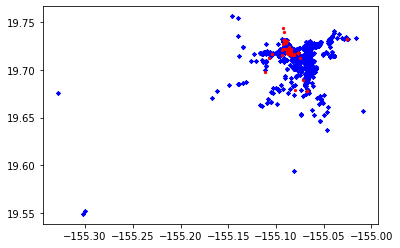

In [179]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
valid_building_footprints.plot(ax=ax, color='blue', markersize=5)
gdf_api_data.plot(ax=ax, color='red', markersize=5)
plt.show()


## spatial index

In [180]:
import geopandas as gpd

# Ensure building footprints have a spatial index
building_footprints_sindex = valid_building_footprints.sindex

for index, point in gdf_api_data.iterrows():
    # Get the nearest building footprint index using the spatial index
    nearest_idx_list = list(building_footprints_sindex.nearest(point['geometry'], return_distance=False))
    nearest_idx = nearest_idx_list[1]  # Change to [1] only if you're sure you need the second nearest
    nearest_geometry = valid_building_footprints.iloc[nearest_idx].geometry

    # Calculate the distance between the point and the nearest building geometry
    distance = point['geometry'].distance(nearest_geometry)

    # Print including the API data point ID and the nearest building index
    print(f"API Data Point Geometry{point['geometry']}")
    print(f"API Data Point ID: {point['id']} - Nearest building index: {nearest_idx}")
    print(f"Distance to nearest building: {distance} meters.")
    print(f"Coordinates of nearest building footprint: {nearest_geometry}")



API Data Point GeometryPOINT (-155.085895 19.718335)
API Data Point ID: 189-Kukuau-St,-Unit-100,-Hilo,-HI-96720 - Nearest building index: [22204 44247  5044 13064 10346 28830 15173 36954 25353 41392 34154 39075
 21636  1783 26010 38545 16041 35119 32753 27300 43751 31054 11766 42450
  6637  2785 19806   166 24206 18369 31942  6437 11633 16986  7995]
Distance to nearest building: 333282    0.000813
541219    0.000813
551951    0.000813
529331    0.000813
532865    0.000813
557456    0.000813
574335    0.000813
544998    0.000813
555392    0.000813
520271    0.000813
6935      0.000813
547439    0.000813
509503    0.000813
519608    0.000813
42223     0.000813
451707    0.000813
13915     0.000813
283307    0.000813
578476    0.000813
525706    0.000813
533775    0.000813
538042    0.000813
584740    0.000813
565668    0.000813
240927    0.000813
329773    0.000813
555794    0.000813
265002    0.000813
526777    0.000813
480221    0.000813
551394    0.000813
441261    0.000813
501378    

API Data Point GeometryPOINT (-155.091557 19.731386)
API Data Point ID: 346-Kauila-St,-Apt-303,-Hilo,-HI-96720 - Nearest building index: [17925  3681 27018 14084 41326 30487 36185 23182 34543 14772 19008  6589
 31177 39323 12538 24808 16161 11617 21974 38151 20307  9969 45281  6374
 43097 24194 41525  4131  1101 29400  8405 37506 33137 27541  1525]
Distance to nearest building: 288737    0.000496
245747    0.000496
449625    0.000496
432004    0.000496
205611    0.000496
482585    0.000496
361650    0.000496
34011     0.000496
540283    0.000496
495423    0.000496
449077    0.000496
16173     0.000496
545014    0.000496
447132    0.000496
475258    0.000496
410807    0.000496
561209    0.000496
410898    0.000496
454013    0.000496
493205    0.000496
536482    0.000496
37609     0.000496
487154    0.000496
141022    0.000496
12691     0.000496
479278    0.000496
516481    0.000496
503553    0.000496
360231    0.000496
37629     0.000496
482722    0.000496
477495    0.000496
469144    0

In [210]:
import geopandas as gpd

# Ensure building footprints have a spatial index
building_footprints_sindex = valid_building_footprints.sindex

# Define the threshold distance (in meters)
threshold_distance = 1 

for index, point in gdf_api_data.iterrows():
    # Get the nearest building footprint indices using the spatial index
    nearest_idx_list = list(building_footprints_sindex.nearest(point['geometry'], return_distance=False))
    
    # Initialize variables to store information about the nearest footprint within the threshold
    nearest_within_threshold_idx = None
    min_distance = float('inf')  # Initialize with a large value
    
    for nearest_idx in nearest_idx_list:
        nearest_geometry = valid_building_footprints.iloc[nearest_idx].geometry
        
        # Calculate the distance between the point and the nearest building geometry
        distance = point['geometry'].distance(nearest_geometry).values[0] if isinstance(point['geometry'].distance(nearest_geometry), pd.Series) else point['geometry'].distance(nearest_geometry)
    
        
        # Ensure distance is a scalar value
        distance_scalar = distance.values[0] if isinstance(distance, pd.Series) else distance
        
        # Check if the distance is within the threshold and smaller than the current minimum distance
        if distance_scalar <= threshold_distance and distance_scalar < min_distance:
            min_distance = distance_scalar
            nearest_within_threshold_idx = nearest_idx
    
    # Print information for the nearest footprint within the threshold
    if nearest_within_threshold_idx is not None:
        nearest_geometry = valid_building_footprints.iloc[nearest_within_threshold_idx].geometry
        #print(nearest_within_threshold_idx)
        print(f"API Data Point ID: {point['id']} - Nearest building index: {nearest_within_threshold_idx}")
        print(f"Distance to nearest building: {min_distance} meters.")
        print(f"Nearest building locations: {valid_building_footprints.iloc[nearest_within_threshold_idx]['street_address']}")
        print(f"Coordinates of nearest building footprint: {nearest_geometry}")
    else:
        print(f"No building footprint within the threshold distance for API Data Point ID: {point['id']}")


API Data Point ID: 189-Kukuau-St,-Unit-100,-Hilo,-HI-96720 - Nearest building index: [31942 24206 15173 18369  6637 44247 22204 13064 41392 42450 10346 11766
 26010  1783 19806 34154 38545 28830  7995 16041 35119 11633 25353  2785
 21636   166 27300 43751  6437 31054 32753  5044 16986 39075 36954]
Distance to nearest building: 0.0008126693133405581 meters.
Nearest building locations: 551394    632 Kinoole St
526777    632 Kinoole St
574335    632 Kinoole St
480221    632 Kinoole St
240927    632 Kinoole St
541219    632 Kinoole St
333282    632 Kinoole St
529331    632 Kinoole St
520271    632 Kinoole St
565668    632 Kinoole St
532865    632 Kinoole St
584740    632 Kinoole St
42223     632 Kinoole St
519608    632 Kinoole St
555794    632 Kinoole St
6935      632 Kinoole St
451707    632 Kinoole St
557456    632 Kinoole St
515752    632 Kinoole St
13915     632 Kinoole St
283307    632 Kinoole St
501378    632 Kinoole St
555392    632 Kinoole St
329773    632 Kinoole St
509503    632

API Data Point ID: 101-Aupuni-St,-Ste-248,-Hilo,-HI-96720 - Nearest building index: [23051 15479 25067 39026 14063  1158 11239 12295  6171 27663 18346 41136
 38535  4635  8524  3737 33121 21265 37065 43837 20523 31200 10308 29072
 45012 26857  7503 23639 35932 17893  2030 42042 30005 16431 34379]
Distance to nearest building: 7.342348169175445e-05 meters.
Nearest building locations: 71466     101 Aupuni St Ste 243
358070    101 Aupuni St Ste 243
428548    101 Aupuni St Ste 243
336734    101 Aupuni St Ste 243
358247    101 Aupuni St Ste 243
17790     101 Aupuni St Ste 243
421000    101 Aupuni St Ste 243
46368     101 Aupuni St Ste 243
445208    101 Aupuni St Ste 243
399896    101 Aupuni St Ste 243
401718    101 Aupuni St Ste 243
520550    101 Aupuni St Ste 243
408664    101 Aupuni St Ste 243
421335    101 Aupuni St Ste 243
420594    101 Aupuni St Ste 243
498396    101 Aupuni St Ste 243
395747    101 Aupuni St Ste 243
10657     101 Aupuni St Ste 243
397840    101 Aupuni St Ste 243
392125

 11617 33137  6374  1101 19008 12538 45281 23182 16161 17925 39323]
Distance to nearest building: 0.0004963836189800531 meters.
Nearest building locations: 536482    345 Kauila St
447587    345 Kauila St
493205    345 Kauila St
508586    345 Kauila St
205611    345 Kauila St
361650    345 Kauila St
482585    345 Kauila St
479278    345 Kauila St
37629     345 Kauila St
449625    345 Kauila St
495423    345 Kauila St
540283    345 Kauila St
516481    345 Kauila St
482722    345 Kauila St
12691     345 Kauila St
477495    345 Kauila St
503553    345 Kauila St
454013    345 Kauila St
245747    345 Kauila St
37609     345 Kauila St
410807    345 Kauila St
432004    345 Kauila St
16173     345 Kauila St
545014    345 Kauila St
410898    345 Kauila St
469144    345 Kauila St
141022    345 Kauila St
360231    345 Kauila St
449077    345 Kauila St
475258    345 Kauila St
487154    345 Kauila St
34011     345 Kauila St
561209    345 Kauila St
288737    345 Kauila St
447132    345 Kauila St
Name

In [213]:
import pandas as pd
import geopandas as gpd

# Ensure building footprints have a spatial index
building_footprints_sindex = valid_building_footprints.sindex

# Define the threshold distance (in meters)
threshold_distance = 1  


# Initialize an empty DataFrame to store results
nearest_buildings_df = pd.DataFrame(columns=['API_Data_Point_ID', 'Nearest_Building_Index', 'Distance_to_Nearest_Building'])

for index, point in gdf_api_data.iterrows():
    # Get the nearest building footprint indices using the spatial index
    nearest_idx_list = list(building_footprints_sindex.nearest(point['geometry'], return_distance=True))
    
    # Filter out indices where the distance is within the threshold
    nearest_within_threshold = [(idx, dist) for idx, dist in zip(*nearest_idx_list) if dist <= threshold_distance]
    
    if nearest_within_threshold:
        # Sort by distance and get the closest building
        nearest_within_threshold.sort(key=lambda x: x[1])
        nearest_idx, min_distance = nearest_within_threshold[0]
        
        # Get information about the nearest building
        nearest_building_info = valid_building_footprints.iloc[nearest_idx]
        
        # Store results in the DataFrame
        nearest_buildings_df = nearest_buildings_df.append({
            'API_Data_Point_ID': point['id'],
            'Nearest_Building_Index': nearest_idx,
            'Distance_to_Nearest_Building': min_distance
        }, ignore_index=True)

# Print the DataFrame with the nearest buildings
print(nearest_buildings_df)


/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nearest_buildings_df = nearest_buildings_df.append({
/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nearest_buildings_df = nearest_buildings_df.append({
/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nearest_buildings_df = nearest_buildings_df.append({
/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nearest_buildings_df = nearest_buildings_df.append({
/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nearest_buildings_df = nearest_buildings_df.append({
/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nearest_buildings_df = nearest_buildings_df.append({
/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

                           API_Data_Point_ID  \
0    189-Kukuau-St,-Unit-100,-Hilo,-HI-96720   
1               55-Kukuau-St,-Hilo,-HI-96720   
2            98-Ponahawai-St,-Hilo,-HI-96720   
3             552-Kinoole-St,-Hilo,-HI-96720   
4           110-Ponahawai-St,-Hilo,-HI-96720   
..                                       ...   
102    265-Kekuanaoa-St,---D,-Hilo,-HI-96720   
103           237-Kaumana-Dr,-Hilo,-HI-96720   
104         349-Ponahawai-St,-Hilo,-HI-96720   
105            45-Amauulu-Rd,-Hilo,-HI-96720   
106    282-Kukuau-St,-Unit-C,-Hilo,-HI-96720   

                                Nearest_Building_Index  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
..                                                 ...   
102  [0, 0, 0, 0,

/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nearest_buildings_df = nearest_buildings_df.append({
/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nearest_buildings_df = nearest_buildings_df.append({
/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nearest_buildings_df = nearest_buildings_df.append({
/var/folders/66/zb_slx1j7jb2s05rx_q138bw0000gn/T/ipykernel_61906/3389845627.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

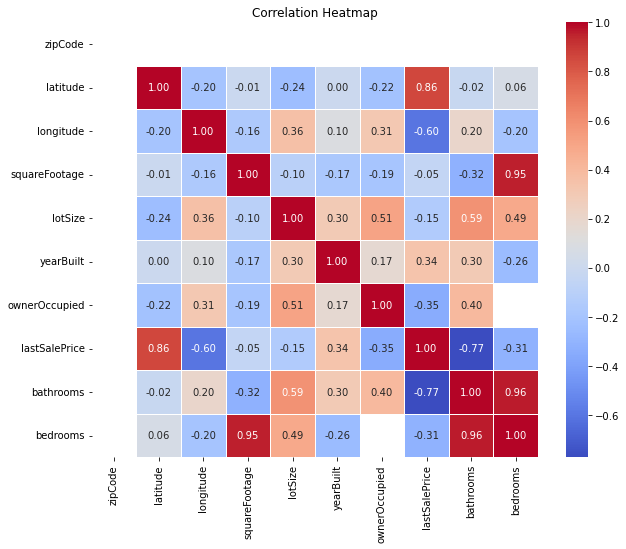

In [219]:
# Merge foot traffic data with apartment building data
merged_data = pd.merge(nearest_buildings_df, gdf_api_data, left_index=True, right_index=True, how='inner')

# EDA: Explore the merged dataset
# For example, you can use descriptive statistics, plot distributions, etc.

# Correlation Analysis
correlation_matrix = merged_data.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [229]:
filtered_footprint_gdf = valid_building_footprints.dropna(subset=['raw_visit_counts'])
filtered_apartment_gdf = gdf_api_data.dropna(subset=['squareFootage'])

## Naive Nearest Neighbor

/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "Geometry column does not contain geometry.",


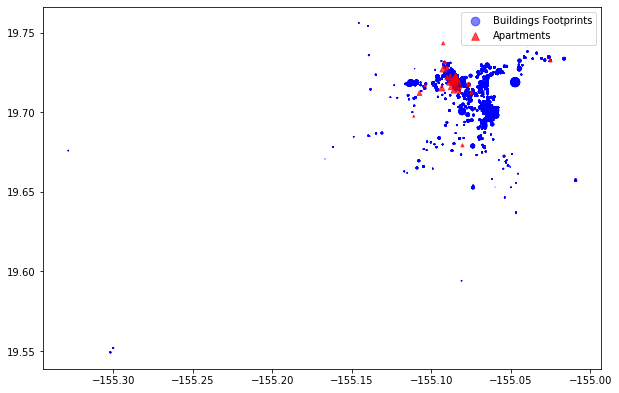

In [237]:
# Calculate the nearest building for each apartment
def get_nearest(src_points, candidates, k_neighbors=1):
    # Use BallTree or cKDTree for efficient spatial queries
    from sklearn.neighbors import BallTree
    import numpy as np

    tree = BallTree(candidates.geometry.apply(lambda geom: [geom.x, geom.y]).tolist(), leaf_size=15, metric='haversine')
    distances, indices = tree.query(src_points.geometry.apply(lambda geom: [geom.x, geom.y]).tolist(), k=k_neighbors)
    
    return indices.ravel()

filtered_apartment_gdf['nearest_building'] = get_nearest(filtered_apartment_gdf, filtered_footprint_gdf)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))


# Scale the size by raw_visit_counts
size_scale = filtered_apartment_gdf['squareFootage'] * 0.01
size_scale_footprint = filtered_footprint_gdf['raw_visit_counts'] * 0.01

# Plot buildings
filtered_footprint_gdf.plot(ax=ax, marker='o', color='blue', alpha=0.5, markersize=size_scale_footprint,label='Buildings Footprints')

# Plot apartments
filtered_apartment_gdf.plot(ax=ax, marker='^', color='red', alpha=0.7, markersize=size_scale, label='Apartments')

plt.legend()
plt.show()

## Enhanced Nearest Neighbor

In [240]:
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree
import numpy as np

# Resetting the index to ensure alignment
filtered_footprint_gdf.reset_index(drop=True, inplace=True)

# Define the function to get the nearest index and distances
def get_nearest(src_points, candidates, k_neighbors=1):
    tree = BallTree(candidates.geometry.apply(lambda geom: [geom.x, geom.y]).tolist(), leaf_size=15, metric='haversine')
    distances, indices = tree.query(src_points.geometry.apply(lambda geom: [geom.x, geom.y]).tolist(), k=k_neighbors)
    distances = distances.ravel() * 6371000  # Convert to meters from radians, assuming Earth radius in meters
    return indices.ravel(), distances

# Get nearest building indices and distances
nearest_indices, nearest_distances = get_nearest(filtered_apartment_gdf, filtered_footprint_gdf)

# Add nearest building information to filtered_apartment_gdf
filtered_apartment_gdf['nearest_building_id'] = nearest_indices
filtered_apartment_gdf['nearest_building_distance'] = nearest_distances

# Correct way to merge using iloc for position-based indexing
filtered_apartment_gdf['nearest_building_address'] = filtered_footprint_gdf.iloc[nearest_indices]['street_address'].values

# Print out the necessary information
for idx, row in filtered_apartment_gdf.iterrows():
    print(f"Apartment ID: {row['id']} - Nearest Building Address: {row['nearest_building_address']}, Distance: {row['nearest_building_distance']} meters")


Apartment ID: 189-Kukuau-St,-Unit-100,-Hilo,-HI-96720 - Nearest Building Address: 528 Kinoole St, Distance: 3799.1815245392404 meters
Apartment ID: 55-Kukuau-St,-Hilo,-HI-96720 - Nearest Building Address: 55 Kukuau St, Distance: 263.3365828934941 meters
Apartment ID: 98-Ponahawai-St,-Hilo,-HI-96720 - Nearest Building Address: 84 Ponahawai St, Distance: 878.5522819000468 meters
Apartment ID: 552-Kinoole-St,-Hilo,-HI-96720 - Nearest Building Address: 524 Kinoole St, Distance: 1751.057843244686 meters
Apartment ID: 110-Ponahawai-St,-Hilo,-HI-96720 - Nearest Building Address: 211 Kilauea Ave, Distance: 1088.3892528773315 meters
Apartment ID: 929-Ululani-St,-Hilo,-HI-96720 - Nearest Building Address: 899 Ululani St Ste 3, Distance: 2644.4934399293275 meters
Apartment ID: 76-Kapiolani-St,-Hilo,-HI-96720 - Nearest Building Address: 72 Kapiolani St, Distance: 358.0532703386245 meters
Apartment ID: 651-Ponahawai-St,-Hilo,-HI-96720 - Nearest Building Address: 522 Ponahawai St, Distance: 2266.866

/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "Geometry column does not contain geometry.",
/Users/kd6801/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "Geometry column does not contain geometry.",


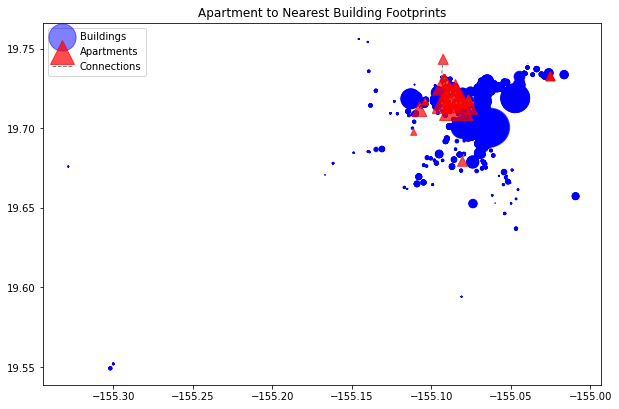

In [245]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Assuming filtered_apartment_gdf and filtered_footprint_gdf are already defined and contain 'geometry'
# Also assuming 'nearest_building_address' and 'nearest_building_distance' are computed

# Create a GeoDataFrame for lines connecting apartments to their nearest buildings
connection_lines = gpd.GeoDataFrame(
    {'geometry': [LineString([apartment, filtered_footprint_gdf.iloc[nb_id].geometry])
                  for apartment, nb_id in zip(filtered_apartment_gdf.geometry, filtered_apartment_gdf.nearest_building_id)]},
    crs=filtered_apartment_gdf.crs
)

fig, ax = plt.subplots(figsize=(10, 10))

# Scale the size by raw_visit_counts
size_scale = filtered_apartment_gdf['squareFootage'] * 0.1
size_scale_footprint = filtered_footprint_gdf['raw_visit_counts'] * 0.1

# Plot building footprints
filtered_footprint_gdf.plot(ax=ax, marker='o', color='blue', label='Buildings', markersize=size_scale_footprint, alpha=0.5)

# Plot apartments
filtered_apartment_gdf.plot(ax=ax, marker='^', color='red', label='Apartments', markersize=size_scale, alpha=0.7)

# Plot connection lines
connection_lines.plot(ax=ax, color='grey', linestyle='--', linewidth=1, label='Connections')

# Set plot title and legend
ax.set_title('Apartment to Nearest Building Footprints')
ax.legend()

# Show plot
plt.show()


In [204]:
# import geopandas as gpd
# from shapely.ops import nearest_points

# # Define the target CRS (e.g., UTM zone suitable for Hawaii)
# target_crs = 'EPSG:32604'  # UTM Zone 4N (Hawaii)

# # Convert the point geometries to a GeoDataFrame
# gdf_points = gpd.GeoDataFrame(gdf_api_data, geometry=gpd.points_from_xy(gdf_api_data['longitude'], gdf_api_data['latitude']))

# # Reproject the entire GeoDataFrame to the target CRS
# gdf_points = gdf_points.to_crs(target_crs)

# # Ensure building footprints have a spatial index
# building_footprints_sindex = valid_building_footprints.sindex

# # Iterate over each point in the API data
# for index, point in gdf_points.iterrows():
#     # Get the nearest building footprint index using the spatial index
#     nearest_idx = list(building_footprints_sindex.nearest(point.geometry, return_distance=False))[0]
#     nearest_geometry = valid_building_footprints.iloc[nearest_idx].geometry

#     # Calculate the distance between the point and the nearest building geometry
#     # using Cartesian distance calculation
#     nearest_point, _ = nearest_points(point.geometry, nearest_geometry)
#     distance = point.geometry.distance(nearest_point)

#     # Print information about the nearest building footprint
#     print(f"API Data Point ID: {point['id']}")
#     print(f"Distance to nearest building: {distance} meters.")


In [181]:
# import geopandas as gpd
# import matplotlib.pyplot as plt

# # Reset the index of building footprints to ensure continuity
# valid_building_footprints = valid_building_footprints.reset_index(drop=True)
# building_footprints_sindex = valid_building_footprints.sindex

# # Add columns for storing indices and distances
# gdf_api_data['nearest_building_idx'] = -1
# gdf_api_data['nearest_distance'] = float('inf')

# for index, point in gdf_api_data.iterrows():
#     # Get the nearest building footprint indices and distances using the spatial index
#     possible_indices, possible_distances = building_footprints_sindex.nearest(point['geometry'], return_distance=True)
#     for idx, dist in zip(possible_indices, possible_distances):
#         # Check and store the index with the minimum distance
#         if dist < gdf_api_data.at[index, 'nearest_distance']:
#             gdf_api_data.at[index, 'nearest_building_idx'] = idx
#             gdf_api_data.at[index, 'nearest_distance'] = dist

# # Now plot both datasets
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot building footprints
# valid_building_footprints.plot(ax=ax, color='gray', alpha=0.5, label='Building Footprints')

# # Plot apartment locations
# gdf_api_data.plot(ax=ax, color='red', markersize=10, label='Apartments')

# # Plot lines between apartments and their nearest building footprint
# for idx, row in gdf_api_data.iterrows():
#     nearest_building_geom = valid_building_footprints.iloc[row['nearest_building_idx']].geometry
#     plt.plot([row['geometry'].x, nearest_building_geom.x],
#              [row['geometry'].y, nearest_building_geom.y], color='blue', linestyle='--', linewidth=1)

# # Enhance the plot with titles and legend
# plt.title('Apartment Locations and Their Nearest Building Footprints')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# ax.legend()

# plt.show()


## Verification

In [182]:
# Find the index where the geometry matches the specified coordinates
index = gdf_api_data[gdf_api_data['geometry'] == Point(-155.09072, 19.730074)].index[0]

print("Index:", index)
gdf_api_data.iloc[index]

Index: 11


id                  Ching-Studios-333-Lehua-St,-Hilo,-HI-96720
formattedAddress    Ching Studios 333 Lehua St, Hilo, HI 96720
addressLine1                        Ching Studios 333 Lehua St
addressLine2                                              None
city                                                      Hilo
state                                                       HI
zipCode                                                  96720
county                                                  Hawaii
latitude                                             19.730074
longitude                                           -155.09072
propertyType                                         Apartment
squareFootage                                              NaN
lotSize                                                    NaN
yearBuilt                                                  NaN
assessorID                                                 NaN
legalDescription                                       

In [183]:
# one of the nearest footprint data


In [184]:
valid_building_footprints.iloc[28198]

placekey                                                   zzw-222@bp4-jcv-bx5
safegraph_place_id                         sg:dd416f6ecdbe4f32b1c7256aecebf972
parent_placekey                                                           None
parent_safegraph_place_id                                                 None
location_name                                            Hilo Bay Facial & Spa
safegraph_brand_ids                                                       None
brands                                                                    None
top_category                                           Other Personal Services
sub_category                                       All Other Personal Services
category_tags                                                             None
naics_code                                                            812990.0
latitude                                                             19.718937
longitude                                           